# Introduction to Python Multiprocessing
## Running Your Experiments on parallel

+ Now we can build a document classifier with scikit-learn and nltk.
+ Next, let's look at ways you can parallelize this.

# A "Hello, World!" in multiprocessing

### 1. Let's find out the number of cores in our system

In [ ]:
import multiprocessing as mp

num_cpu = mp.cpu_count()

print("Number of cpu cores: {}".format(num_cpu))

## 2. Let's run a process on each of those four cores



In [ ]:
from time import sleep
import multiprocessing as mp
import random
def func(arg):
    sleep(5)
    print("Hello, world! {}".format(arg))
    

if __name__ == "__main__":
    num_cpu = mp.cpu_count()
    args = list(range(num_cpu))
    print(args)
    with mp.Pool(num_cpu) as p:
        res = p.map(func, args)
    

## 3. Chunks of processes

+ What is chunking?
+ Say you have 4 cores, and 16 processes. 
+ You can ask python to run them in batches of say 4.

Let's see how we do that.

In [ ]:
from time import sleep
import multiprocessing as mp
import random
def par_func(arg):
    sleep(5)
    print("Hello, world! {}".format(arg))
    

if __name__ == "__main__":
    num_cpu = mp.cpu_count()
    args = list(range(4 * num_cpu)) # 16 processes
    print(args, "\n")
    with mp.Pool(num_cpu) as p:
        res = p.map_async(func, args, chunksize=4).get()
                                  # ----------- #
                                  # This is your batch size #

## 4. Run Processes Asynchronously

+ Map waits for processes to complete.
+ This can lead to deadlocks, concurrency issues, etc.
+ You can do a lazy execution with asynchronous processes

In [ ]:
from time import sleep
import multiprocessing as mp
import random

def func(arg):
    sleep(5)
    print("Hello, world! {}".format(arg))
    

if __name__ == "__main__":
    num_cpu = mp.cpu_count()
    args = list(range(4 * num_cpu)) 
    print(args, "\n")
    
    with mp.Pool(num_cpu) as p:
        res = p.map_async(func, args, chunksize=4)
              # --------- #
              # see this? #
        res.get()

## 5. Partial functions!

+ Say you have more than one arguments. How to you solve that?

We can use partial functions.

In [ ]:
from functools import partial

def add(a, b):
    return a + b

add_2 = partial(add, b=2)

add_2(3)

### Now, let's run this parallely

In [ ]:
from functools import partial
from time import sleep

def add(a, b):
    sleep(2)
    return print("{} + {} = {}".format(a,b,a+b))

if __name__ == "__main__":
    num_cpu = mp.cpu_count()
    args = list(range(4 * num_cpu)) 
    print(args, "\n")

    add_5 = partial(add, b=5)
    
    with mp.Pool(num_cpu) as p:
        res = p.map_async(add_5, args, chunksize=4)
                         #-----#
                #The partial function#
        res.get()

# Running sklearn parallely

This will be fun, let's run sklearn on the MNIST data 
+ With a 10 fold cross validation
+ On 4 cores. 

In [ ]:
import numpy as np
from functools import partial
from sklearn import datasets
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.base import clone  
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.datasets import fetch_mldata


# Define a function to run a cross val and return F1 score
# --------------------------------------------------------
def cross_val(train_index, test_index, clf):
    
    cloned_clf = clone(clf)

    # Training data
    # -------------
    X_train_folds = X[train_index]
    y_train_folds = y[train_index]
    
    # Testing data
    # ------------
    X_test_folds = X[test_index]
    y_test_folds = y[test_index]
    
    # Fit a classifier on the training data
    # -------------------------------------
    cloned_clf.fit(X_train_folds, y_train_folds)
    
    # Make predictions on a test set
    # ------------------------------
    y_hat = cloned_clf.predict(X_test_folds)
    
    # Compute some metrics here. Like Precision, Recall, False Alarm, or what have you.
    # ---------------------------------------------------------------------------------
    cmat = confusion_matrix(y_test_folds, y_hat)
    
    # Precision
    # ---------
    prec = 0 if not cmat[1,1] else cmat[1,1]/(cmat[1,1]+cmat[0,1])
    
    # Recall
    # ------
    recall = 0 if not cmat[1,1] else cmat[1,1]/(cmat[1,1]+cmat[1,0])
    
    return recall

if __name__ == "__main__":

    # Get CPU counts
    # --------------
    num_cpu = mp.cpu_count()

    # Load Data
    # ---------
    mnist = fetch_mldata('MNIST original')

    # Training
    # --------
    # Lets use 2 features

    X = mnist["data"]
    y = (mnist["target"] == 5)
    
    # Instantiate Base Classifier
    # ---------------------------
    svm_clf = LinearSVC(C=1, loss="hinge")
    sgd_clf = SGDClassifier(random_state=0, max_iter=500, tol=1e-6)  

    # Create k folds
    # --------------
    skfolds = StratifiedKFold(n_splits=10, random_state=0)
    
    svm_cross_val = partial(cross_val, clf=svm_clf)
    sgd_cross_val = partial(cross_val, clf=sgd_clf)
    
    with mp.Pool(num_cpu) as p:
        result_svm = p.starmap_async(svm_cross_val, skfolds.split(X, y)).get()
        result_sgd = p.starmap_async(sgd_cross_val, skfolds.split(X, y)).get()
        

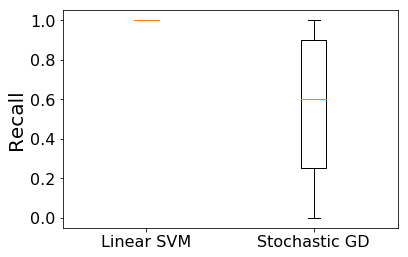

In [118]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Setup Matplotlib
# ----------------

# Font sizes
# ----------
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 36
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.figure(figsize=(6,4))
plt.boxplot([result_svm, result_sgd], labels=['Linear SVM', 'Stochastic GD'])
plt.ylabel('Recall')
plt.show()